/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

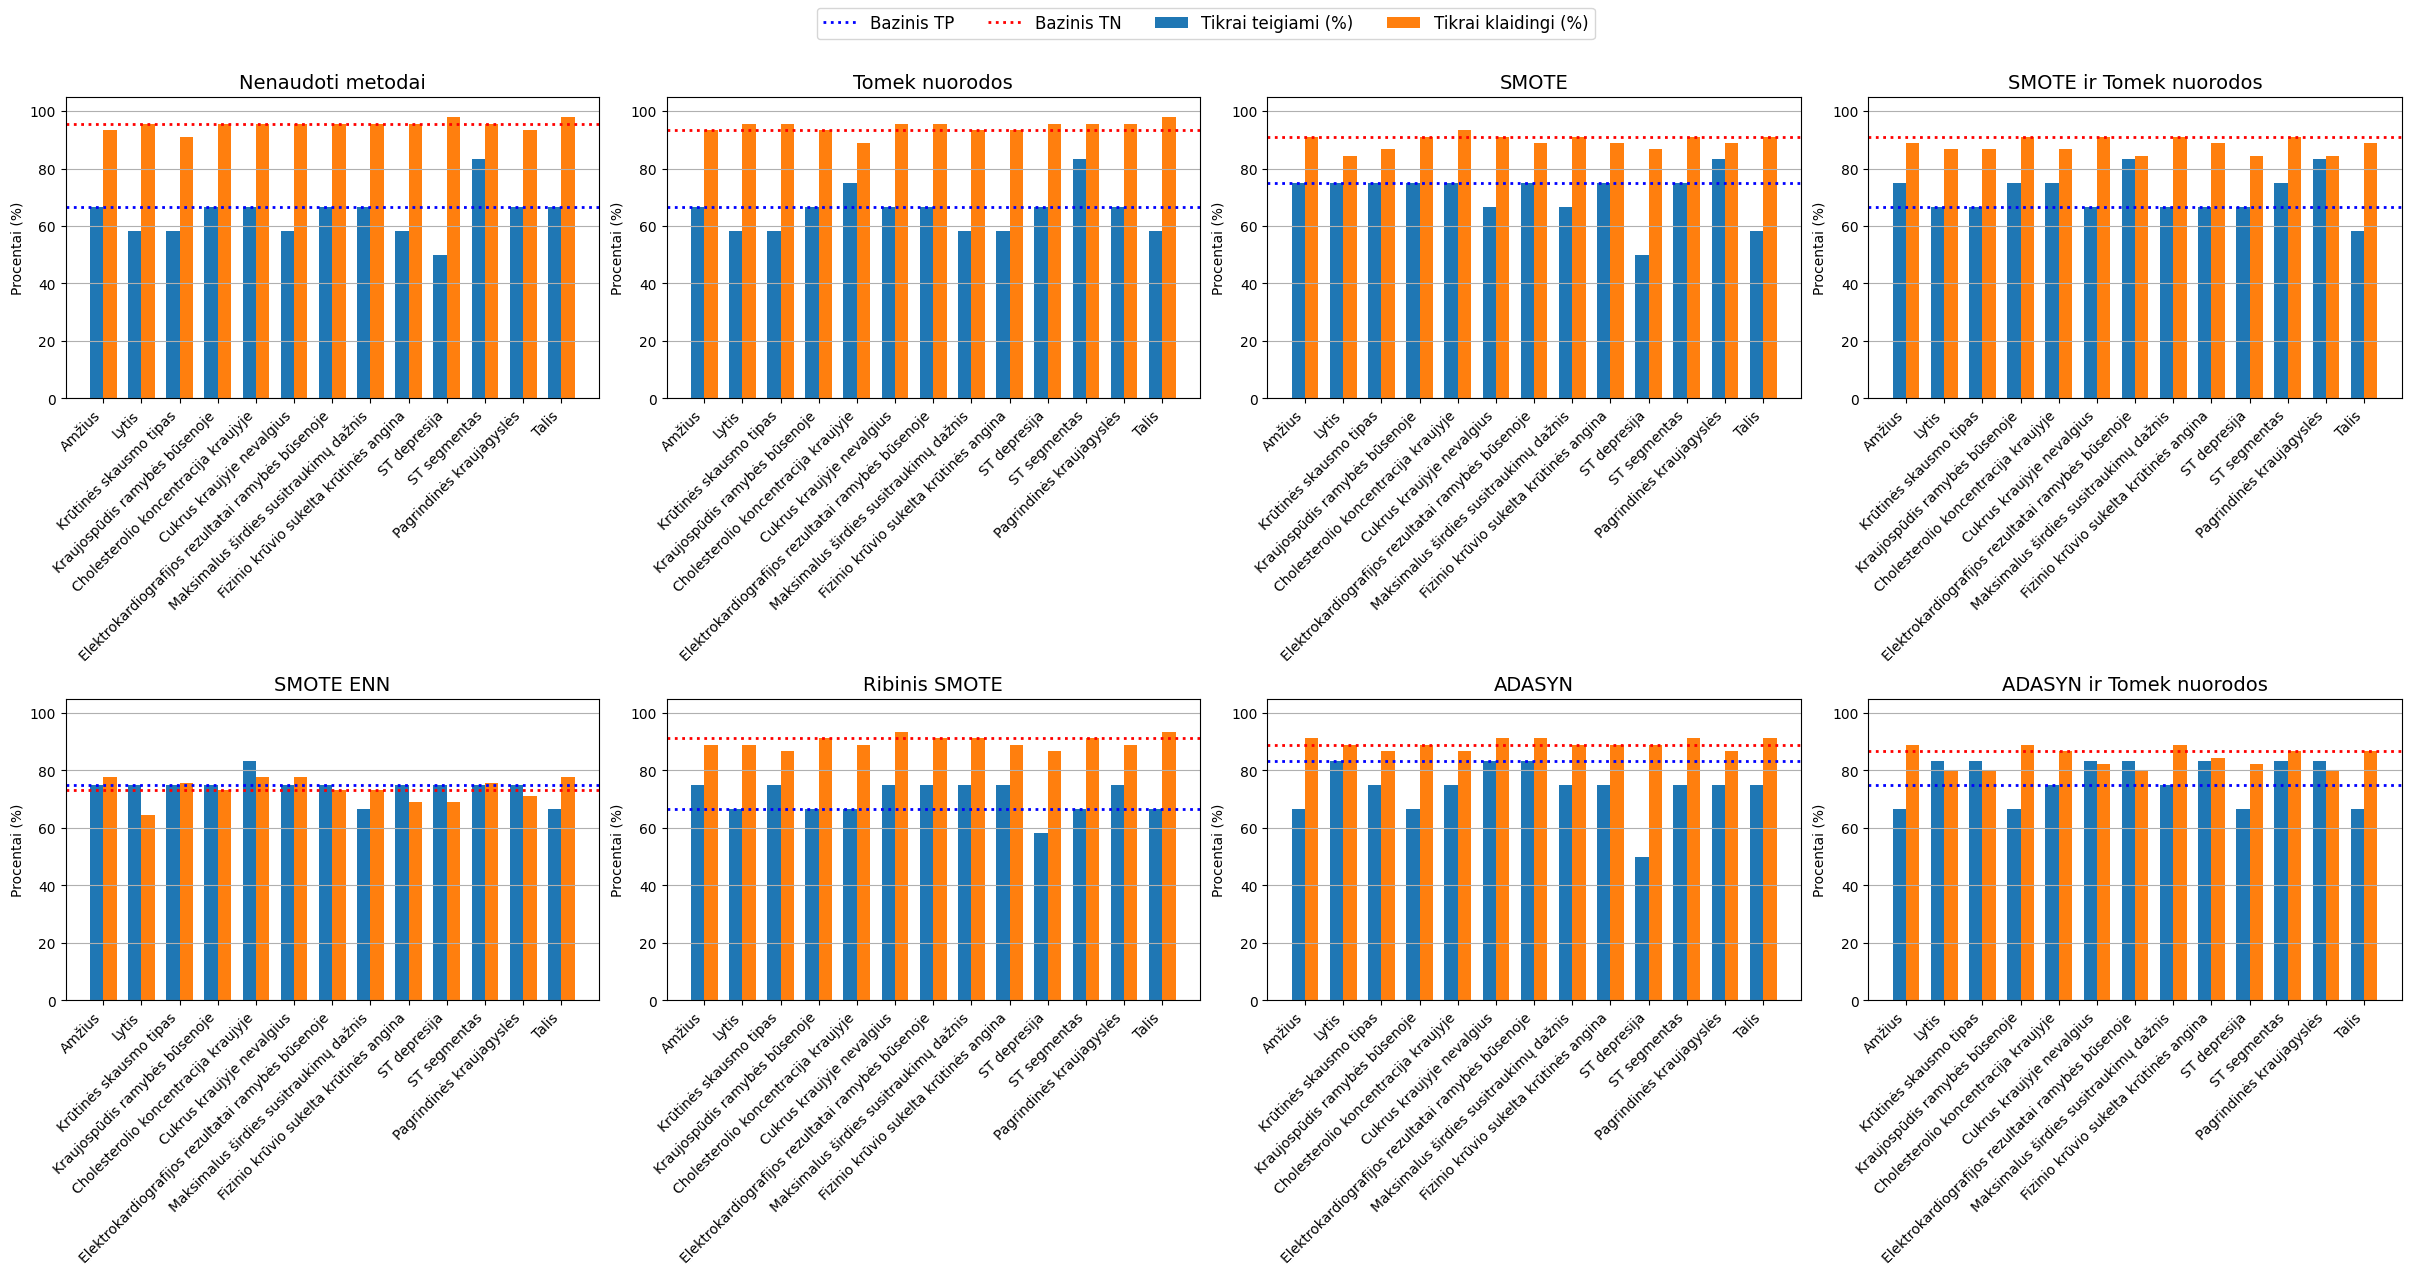

In [ ]:
# MLP daugumos ir mažumos klasių klasifikavimo priklausomybė nuo duomenų požymių 
# bei naudojamų skirtingų metodų

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline


df = pd.read_csv('dataset_heart_reduced.csv', encoding='utf-8-sig')
X = df.drop(columns=['Širdies liga'])
y = df['Širdies liga']

scaler = StandardScaler()
def train_and_evaluate(X_train, y_train, X_test, y_test):
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=7)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp.fit(X_train_scaled, y_train)
    preds = mlp.predict(X_test_scaled)
    cm = confusion_matrix(y_test, preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    return cm_percent[1, 1], cm_percent[0, 0]  # TP, TN

def evaluate_method(method_name, sampler=None):
    tp_list, tn_list, features_removed = [], [], []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
    if sampler:
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
    baseline_tp, baseline_tn = train_and_evaluate(X_train_resampled, y_train_resampled, X_test, y_test)

    for feature in X.columns:
        X_temp = X.drop(columns=[feature])
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y, test_size=0.3, random_state=7, stratify=y)
        if sampler:
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_temp, y_train_temp)
        else:
            X_train_resampled, y_train_resampled = X_train_temp, y_train_temp
        tp, tn = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_temp, y_test_temp)
        tp_list.append(tp)
        tn_list.append(tn)
        features_removed.append(feature)

    return baseline_tp, baseline_tn, tp_list, tn_list, features_removed

adasyn_tomek = ImbPipeline([
    ('adasyn', ADASYN(sampling_strategy=0.99, random_state=7)),
    ('tomek', TomekLinks())
])

methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    (SMOTETomek(sampling_strategy=0.99, random_state=7), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    (adasyn_tomek, "ADASYN ir Tomek nuorodos"),
]


fig, axes = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)
axes = axes.flatten()

for i, (sampler, title) in enumerate(methods):
    baseline_tp, baseline_tn, tp_list, tn_list, features_removed = evaluate_method(title, sampler)

    ax = axes[i]
    indices = np.arange(len(features_removed))
    width = 0.35

    bar1 = ax.bar(indices, tp_list, width, label='Tikrai teigiami (%)')
    bar2 = ax.bar(indices + width, tn_list, width, label='Tikrai klaidingi (%)')

    ax.axhline(y=baseline_tp, color='blue', linestyle=':', linewidth=2, label='Bazinis TP')
    ax.axhline(y=baseline_tn, color='red', linestyle=':', linewidth=2, label='Bazinis TN')

    ax.set_title(title, fontsize=14)
    ax.set_xticks(indices + width / 2)
    ax.set_xticklabels(features_removed, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, 105)
    ax.set_ylabel('Procentai (%)')

    ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=12)


plt.suptitle(
    ' ',
    fontsize=18,
    y=1.05             
)
# plt.savefig("heart_removed_all.png", dpi=300, bbox_inches='tight')

plt.show()
